In [308]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import random

plt.rcParams['font.sans-serif'] = ['SimHei']

## Load Dataset

In [309]:
df1 = pd.read_csv('Datasets\Aggregation.txt', header= None,sep=' ')
data1 = df1.values
data1[:5,:]

array([[15.55, 28.65],
       [14.9 , 27.55],
       [14.45, 28.35],
       [14.15, 28.8 ],
       [13.75, 28.05]])

In [310]:
df2 = pd.read_csv('Datasets\D31.txt', header= None,sep=' ')
data2 = df2.values
data2[:5,:]

array([[25.0514,  5.7475],
       [26.6614,  7.3414],
       [25.2653,  6.2466],
       [25.2285,  4.7447],
       [25.7529,  5.1564]])

In [311]:
df3 = pd.read_csv('Datasets\R15.txt', header= None,sep=' ')
data3 = df3.values
data3[:5,:]

array([[ 9.802, 10.132],
       [10.35 ,  9.768],
       [10.098,  9.988],
       [ 9.73 ,  9.91 ],
       [ 9.754, 10.43 ]])

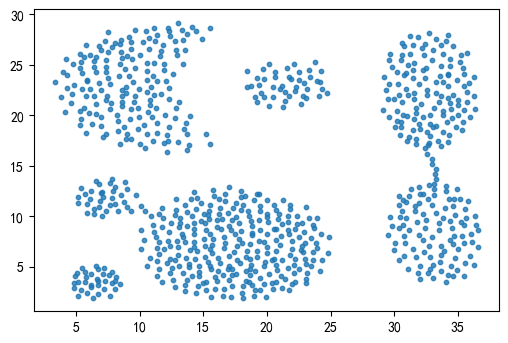

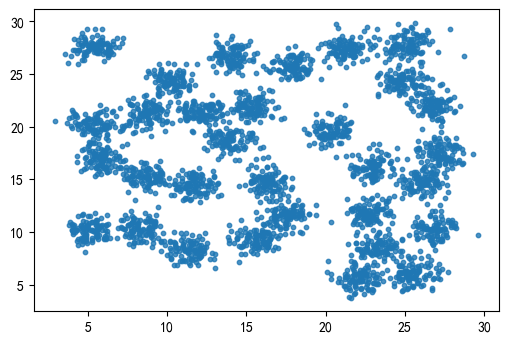

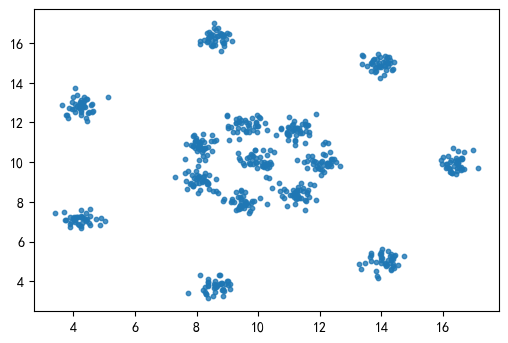

In [312]:
plt.figure(dpi = 100)
plt.scatter(data1[:,0],data1[:,1],s=10,alpha=0.8)
plt.show()
plt.figure(dpi = 100)
plt.scatter(data2[:,0],data2[:,1],s=10,alpha=0.8)
plt.show()
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1],s=10,alpha=0.8)
plt.show()

## DPC

In [313]:
class DPC(object):
    '''
    data : 数据集
    centers : 簇中心的索引
    d_c : 截断距离
    k : 簇的数量
    cluster : 数据对应的簇
    rho : 密度
    delta : 距离
    percent : 选取dc时的比例
    '''
    def __init__(self):
        self.centers = None
        self.d_c = None
        self.k = None
        self.cluster = None
        self.rho = None
        self.delta = None
        self.percent = None
        self.noise_percent = None

    def Distance(self,data):
        m = data.shape[0]
        distance = np.zeros([m,m])
        distance = np.linalg.norm(data-data[:,None],axis=-1)
        # for i in range(m):
        #     for j in range(m):
        #         distance[i,j] = np.sqrt((data[i,0]-data[j,0])**2+(data[i,1]-data[j,1])**2)
        return distance

    def get_d_c(self, distance, per):
        n = int(per * (len(distance)**2))
        dis_plus = np.sort(np.reshape(distance,len(distance)**2))
        d_c = dis_plus[n]
        return d_c

    def LocalDensity(self, distance, d_c):
        m = distance.shape[0]
        rho = np.zeros(m)
        for i in range(m):
            rho[i] = np.sum(np.where(distance[i,:] < d_c, 1, 0)) 
        return rho

    def Delta(self,distance, rho):
        m = distance.shape[0]
        delta = np.zeros(m)
        nearest_neighbor = np.zeros(m)
        rho_index = np.argsort(-rho) # 密度降序的索引
        for i in range(m):
            if i == 0:
                delta[rho_index[i]] = np.max(distance[rho_index[i],:])
                continue
            # 比当前点密度大的序号
            greater_index = rho_index[:i]
            # 当前点的高密度最小距离
            delta[rho_index[i]] = np.min(distance[rho_index[i],greater_index])
            # 密度高于当前点的最近点序号
            nearest_neighbor[rho_index[i]] = greater_index[np.argmin(distance[rho_index[i],greater_index])]
        
        return delta , nearest_neighbor

    def get_k(self,rho,delta):
        product = rho * delta
        aver = np.average(product)
        product_index = np.argsort(-product)
        for i,j in enumerate(product_index):
            if product[j] < 8*aver:
                self.k = i
                break

    def Centers(self,rho,delta):
        product = rho * delta
        product_index = np.argsort(-product)
        self.centers = product_index[:self.k]
        return

    def Clustering(self,nearest_neighbor):
        for i,center in enumerate(self.centers):
            self.cluster[center] = i + 1
            # print(center,self.cluster[center])
        rho_index = np.argsort(-self.rho)
        for i in range(len(self.rho)):
            if self.cluster[rho_index[i]] == 0:
                self.cluster[rho_index[i]] = self.cluster[int(nearest_neighbor[rho_index[i]])]
        return

    def Norm(self, data):
        Min = np.min(data)
        Max = np.max(data)
        norm_data = (data - Min) / (Max - Min)
        return norm_data

    def Noise(self, distance, rho):
        # s = set()
        bord_rho = np.zeros(self.k)
        for i in range(len(distance)):
            for j in range(len(distance)):
                if (distance[i][j] < self.d_c) and (self.cluster[i] != self.cluster[j]):
                    rho_aver = (rho[i] + rho[j]) / 2
                    if (rho_aver>bord_rho[int(self.cluster[i])-1]):
                        bord_rho[int(self.cluster[i])-1]=rho_aver
                    if (rho_aver>bord_rho[int(self.cluster[j])-1]):
                        bord_rho[int(self.cluster[j])-1]=rho_aver
                    # s.add(i)
                    # s.add(j)
        # for i in s:
        #     self.cluster[i] = 0
        for i in range(len(rho)):
            if rho[i] < bord_rho[int(self.cluster[i])-1]:
                self.cluster[i] = 0
        # rho_index = np.argsort(rho)
        # for i in rho_index[:int(self.noise_percent * len(rho))]:
        #     self.cluster[i] = 0


    def ShowCluster(self,data):
        colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F'] # 颜色列表
        plt.figure(dpi = 200)
        for i in range(self.k):
            color = ""
            for j in range(6):
                color += colorArr[random.randint(0,14)] # 随机RGB
            color = '#' + color
            x,y=data[self.cluster == i + 1][:,0],data[self.cluster == i + 1][:,1]
            plt.scatter(x,y,c=color,label='cluster '+str(i+1), s = 10, alpha=0.8)
        
        x,y=data[self.cluster == 0][:,0],data[self.cluster == 0][:,1]
        plt.scatter(x,y,c='black',label = 'noise', s=1)
        plt.scatter(data[self.centers,0],data[self.centers,1], c = 'black', marker= '+',label='centers')
        col = int(len(self.centers) / 15) + 1
        plt.legend(loc='upper right',bbox_to_anchor=(1 + col*0.29,1.0),borderaxespad=0.,ncol = col)
        plt.show()

    def ShowRhoDelta(self):
        plt.figure(dpi = 100)
        plt.xlabel("ρ")
        plt.ylabel("δ")
        plt.title('Decision Graph')
        plt.scatter(self.rho, self.delta, c='none', edgecolors='black', marker='o', alpha=0.5)
        plt.show()
        return

    def ShowGamma(self):
        plt.figure(dpi = 100)
        plt.xlabel("n")
        plt.ylabel("γ")
        plt.title("γ-n picture")
        plt.scatter(list(range(len(self.rho))), np.abs(np.sort(-self.rho * self.delta)), c='black', marker='o', alpha=0.5)
        plt.show()
        return

    def fit(self,data, percent = 0.01, noise_percent = 0.01):
        self.percent = percent
        self.noise_percent = noise_percent
        self.cluster = np.zeros(data.shape[0])
        distance = self.Distance(data)
        self.d_c = self.get_d_c(distance, percent)
        rho = self.LocalDensity(distance, self.d_c)
        self.rho = rho
        delta, nearest_neighbor = self.Delta(distance, rho)
        self.delta = delta
        self.get_k(rho, delta)
        self.Centers(rho, delta)
        self.Clustering(nearest_neighbor)
        #self.Noise(distance,rho)


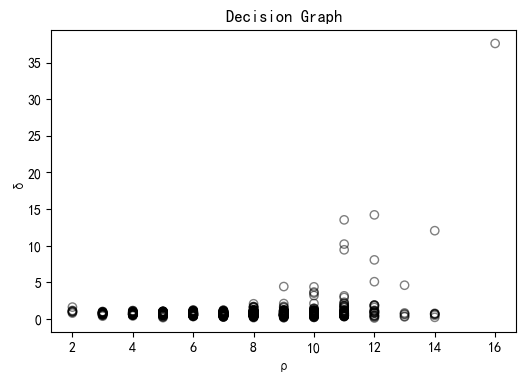

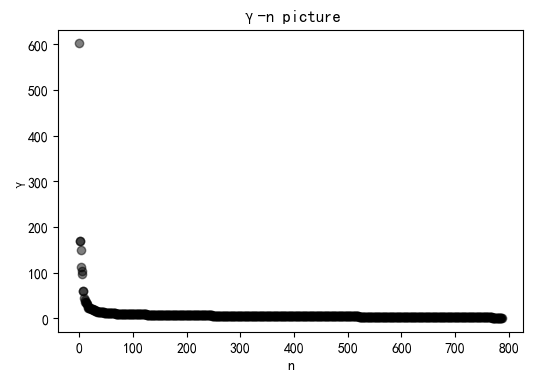

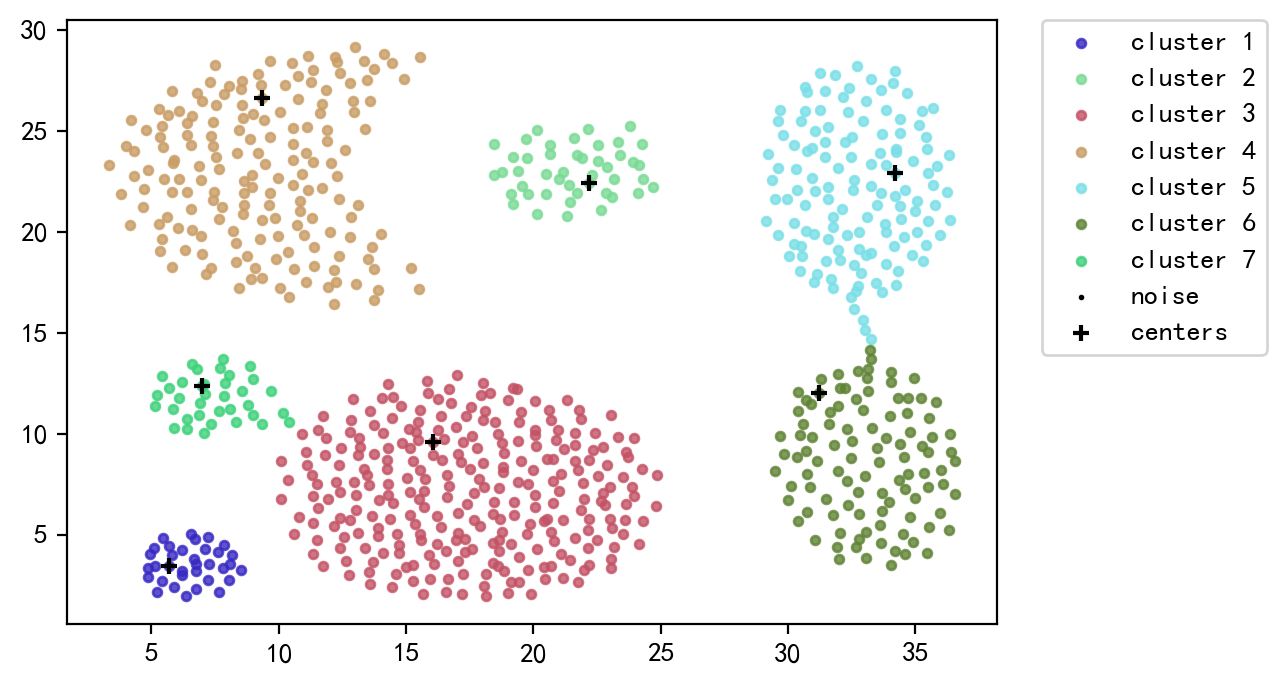

In [314]:
model1 = DPC()
model1.fit(data1,0.01)
model1.ShowRhoDelta()
model1.ShowGamma()
model1.ShowCluster(data1)

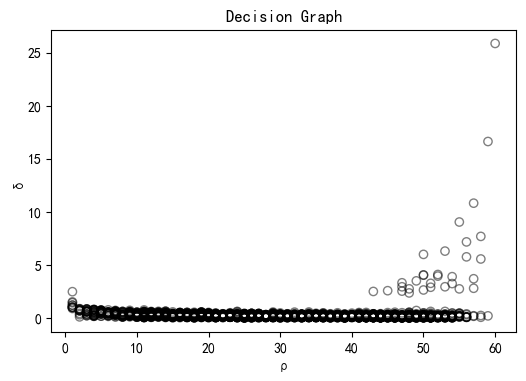

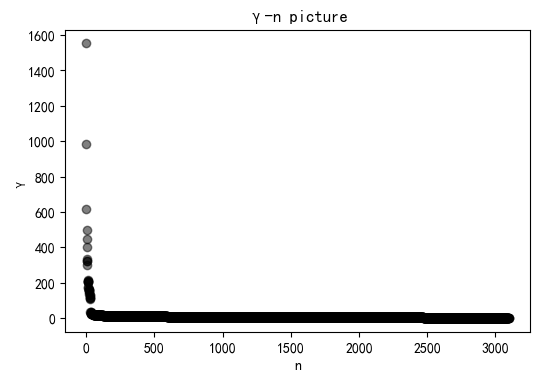

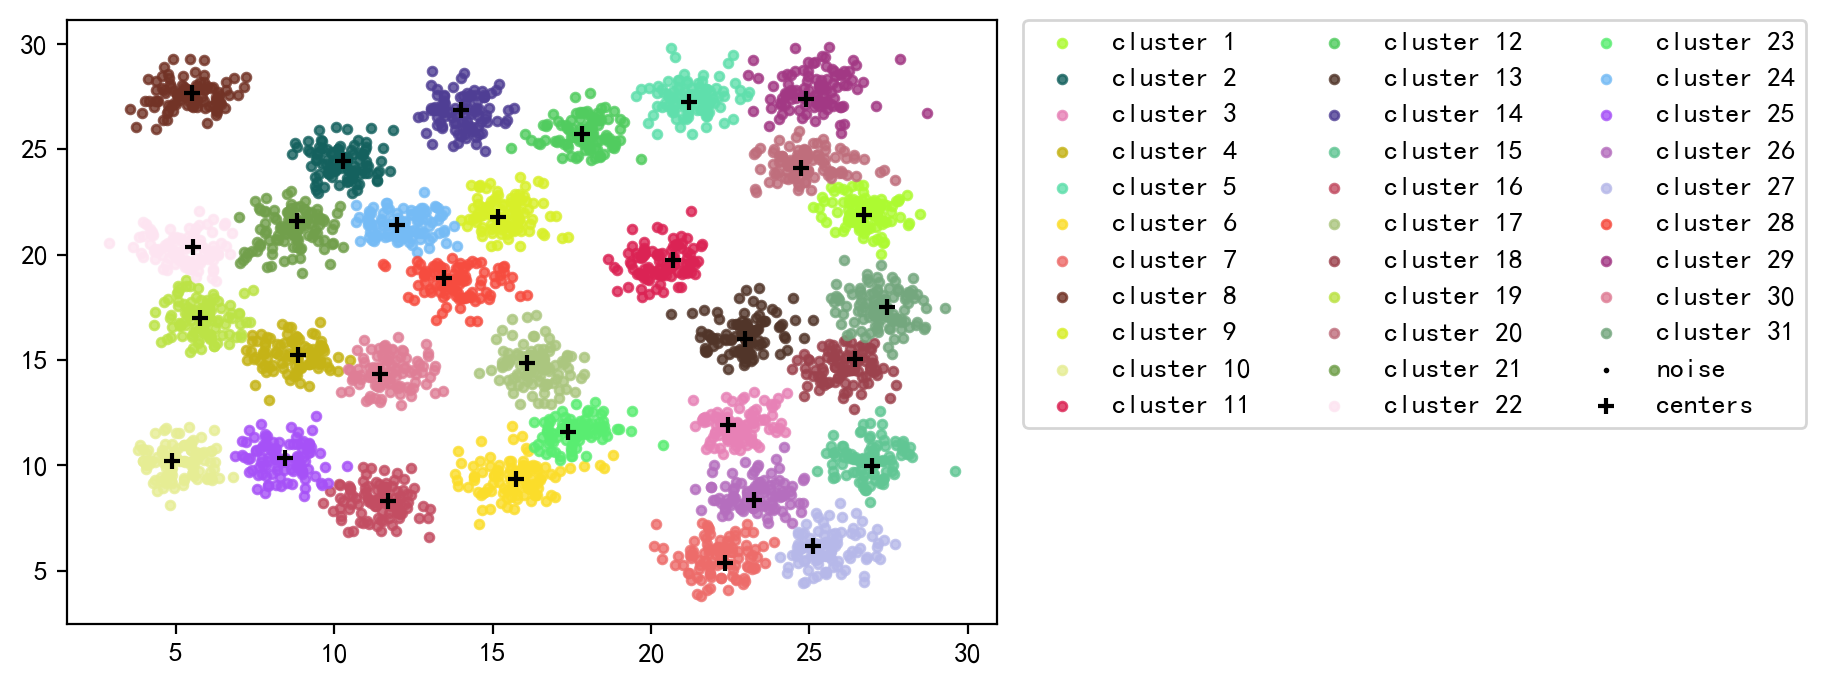

In [315]:
model2 = DPC()
model2.fit(data2,0.01)
model2.ShowRhoDelta()
model2.ShowGamma()
model2.ShowCluster(data2)

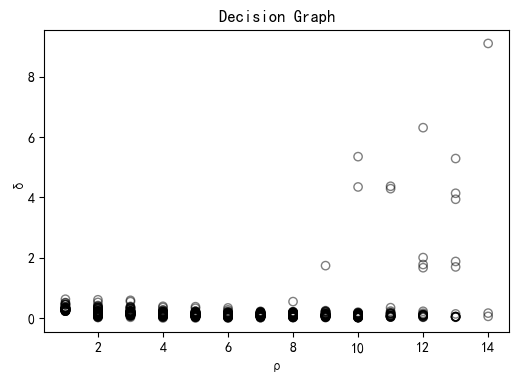

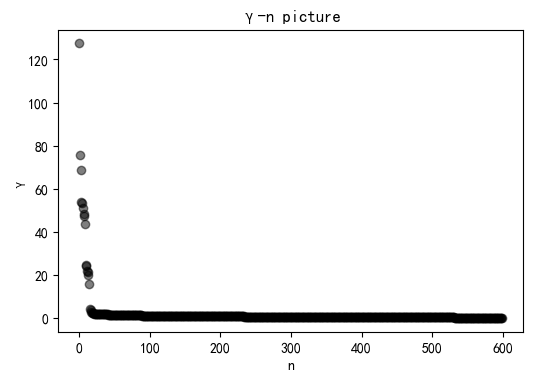

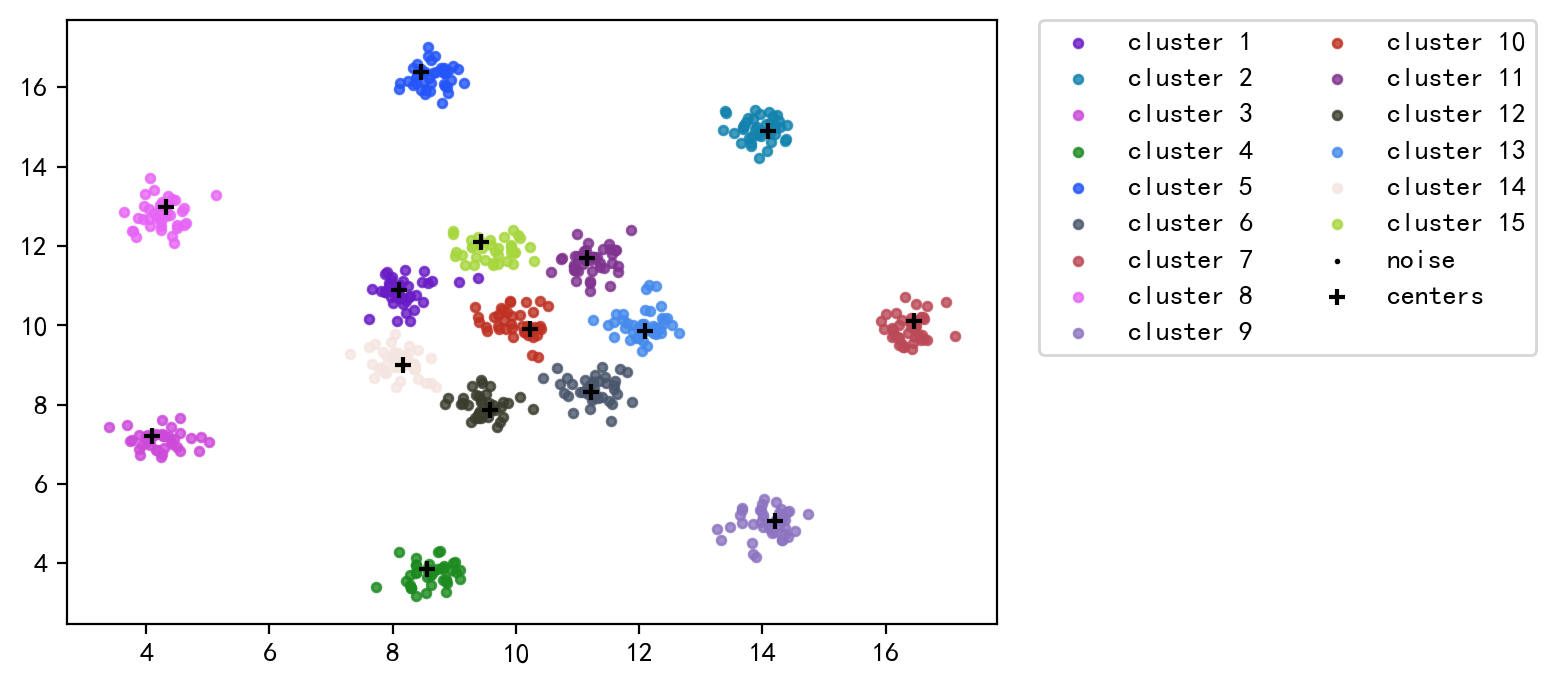

In [316]:
model3 = DPC()
model3.fit(data3,0.01)
model3.ShowRhoDelta()
model3.ShowGamma()
model3.ShowCluster(data3)

In [320]:
from sklearn import metrics

print(metrics.davies_bouldin_score(data1,model1.cluster))
print(metrics.davies_bouldin_score(data2,model2.cluster))
print(metrics.davies_bouldin_score(data3,model3.cluster))

0.5066329067070742
0.5510264905853722
0.3142726133753593


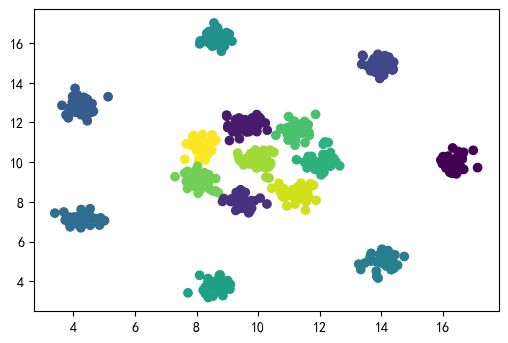

In [318]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=15).fit_predict(data3)
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1], c=y_pred)
plt.show()

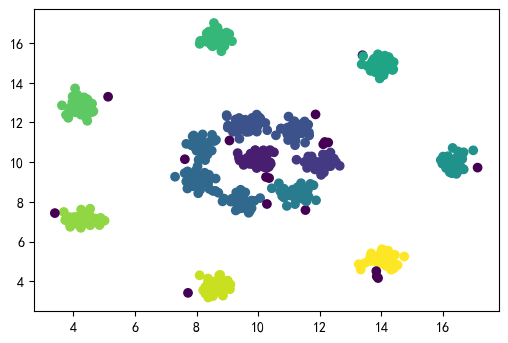

In [319]:
from sklearn.cluster import DBSCAN

y_pred = DBSCAN(eps=0.4).fit_predict(data3)
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1],c=y_pred)
plt.show()